In [1]:
import sklearn as sk
import numpy as np     
import csv 
import copy 
import random 
import pandas as pd
import pickle
import json  
import openpyxl
import itertools
import pymatgen as mg
import scipy

# Libraries for feature selection
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

# User Defined libraries
import utils_dataset as utilsd

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Tick parameters
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = [
#     r'\usepackage{amsmath}',
#     r'\usepackage{amssymb}']
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['legend.fontsize'] = 15

In [2]:
class inputs:
    def __init__(self,input_type='MgAlloys_Hardness_phys',
                 input_path='/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/Weihs_group_datasets/Sreenivas_MgAlloyColab/ST_study_data/Updated_Data_29Nov2023/',
                 input_file='MicroStructureHardness_physDesc.csv',add_target_noise = False):
        self.input_type = input_type
        self.input_path = input_path
        self.input_file = input_file
        self.add_target_noise = add_target_noise
        self.filename   = self.input_path +'/'+ self.input_file
        
    def read_inputs(self):
        print('Reading data for the input dataset type: ', self.input_type)
        
        # Add options for different datasets that we want to read
        if self.input_type == 'MgAlloys_Hardness_phys':
        	XX, YY, descriptors = self.read_MgAlloys_Hardness_phys() 
        elif self.input_type == 'MgAlloys_Corrosion_phys':
        	XX, YY, descriptors = self.read_MgAlloys_Corrosion_phys() 
        elif self.input_type == 'MgAlloys_Hardness':
        	XX, YY, descriptors = self.read_MgAlloys_Hardness() 
        elif self.input_type == 'MgAlloys_Corrosion':
        	XX, YY, descriptors = self.read_MgAlloys_Corrosion()             
        elif self.input_type == 'AlAlloys':
        	XX, YY, descriptors = self.read_AlAlloys()               
        return XX, YY, descriptors   
    
    def read_MgAlloys_Hardness_phys(self):
        '''
        This function reads the dataset from the HEA review paper: https://www.nature.com/articles/s41597-020-00768-9
        input_type='MgAlloys_Hardness_phys',
        input_path='/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/Weihs_group_datasets/Sreenivas_MgAlloyColab/ST_study_data/Updated_Data_Feb2024/',
        input_file='MicroStructureHardness_physDesc.csv'
        '''     
        data = pd.read_csv(self.filename)
 
        descriptors = ['Grain_size_sqrt', 'Disloc_den_sqrt', 'Ca2Mg6Zn3_PartSize_Spacing', 'Mg2Ca_PartSize_Spacing', 'Mn_PartSize_Spacing', '10-10/0002', '11-20/0002'] 
        
        XX = pd.DataFrame(data, columns=descriptors)        
        target = copy.deepcopy(data['Target'].to_numpy())
        YY = target.reshape(-1,1)

        return XX, YY, descriptors
    
    def read_MgAlloys_Corrosion_phys(self):
        '''
        This function reads the dataset from the HEA review paper: https://www.nature.com/articles/s41597-020-00768-9
        input_type='MgAlloys_Corrosion_phys',
        input_path='/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/Weihs_group_datasets/Sreenivas_MgAlloyColab/ST_study_data/Updated_Data_Feb2024/',
        input_file='MicroStructureCorrosion_physDesc.csv'
        '''     
        data = pd.read_csv(self.filename)
 
        descriptors = ['Grain_size_sqrt', 'Disloc_den', 'Ca2Mg6Zn3_delE', 'Mg2Ca_delE', 'Mn_delE', '10-10/0002', '11-20/0002'] #data.columns[0:11] #['Grain_size_mean', 'Disloc_den', 'Ca2Mg6Zn3', 'Mg2Ca', 'Mn',
        
        XX = pd.DataFrame(data, columns=descriptors)        
        target = copy.deepcopy(data['Target'].to_numpy())
        YY = target.reshape(-1,1)

        return XX, YY, descriptors

    def read_MgAlloys_Hardness(self):
        '''
        This function reads the dataset from the HEA review paper: https://www.nature.com/articles/s41597-020-00768-9
        input_type='MgAlloys_Hardness',
        input_path='/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/Weihs_group_datasets/Sreenivas_MgAlloyColab/ST_study_data/Updated_Data_29Nov2023/',
        input_file='MicroStructureHardness.csv'
        '''     
        data = pd.read_csv(self.filename)
 
        descriptors = ['Grain_size_mean', 'Disloc_den', 'Ca2Mg6Zn3_VF', 'Mg2Ca_VF', 'Mn_VF', '10-10/0002', '11-20/0002'] 
        
        XX = pd.DataFrame(data, columns=descriptors)        
        target = copy.deepcopy(data['Target'].to_numpy())
        YY = target.reshape(-1,1)

        return XX, YY, descriptors
    
    def read_MgAlloys_Corrosion(self):
        '''
        This function reads the dataset from the HEA review paper: https://www.nature.com/articles/s41597-020-00768-9
        input_type='MgAlloys_Corrosion',
        input_path='/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/Weihs_group_datasets/Sreenivas_MgAlloyColab/ST_study_data/Updated_Data_29Nov2023/',
        input_file='MicroStructureCorrosion.csv'
        '''     
        data = pd.read_csv(self.filename)
 
        descriptors = ['Grain_size_mean', 'Disloc_den', 'Ca2Mg6Zn3_VF', 'Mg2Ca_VF', 'Mn_VF', '10-10/0002', '11-20/0002'] 
        
        XX = pd.DataFrame(data, columns=descriptors)        
        target = copy.deepcopy(data['Target'].to_numpy())
        YY = target.reshape(-1,1)

        return XX, YY, descriptors
    
    def read_AlAlloys(self):
        '''
        This function reads the dataset from the HEA review paper: https://www.nature.com/articles/s41597-020-00768-9
        input_type='AlAlloys',
        input_path='/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/Weihs_group_datasets/Jesse_colab/',
        input_file='AluminumFragmentDataforML.csv'
        '''     
        data = pd.read_csv(self.filename)
 
        descriptors = data.columns[0:10]
        XX = pd.DataFrame(data, columns=['Volume_Weighted_PSD_Mean','DOS','UTS','Elong_to_Failure','YS'])   # 'Modulus_of_Toughness','Normalized_MOT',
        target = copy.deepcopy(data['D43'].to_numpy())
        YY = target.reshape(-1,1)

        return XX, YY, XX.columns 
    

In [3]:
class feature_selection_algorithms:

    def __init__(self,XX,YY,test_size=0.33,random_state=42):
        
        # Train Data
        # self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(XX, YY, test_size=test_size, random_state=random_state)
        self.X_train = XX
        self.y_train = YY
        
    # LASSO 
    def lasso(self,alpha_range=np.arange(0.001,0.1,0.001)):
        pipeline = Pipeline([('scaler',StandardScaler()),('model',Lasso())])
        search = GridSearchCV(pipeline,{'model__alpha':alpha_range},cv = LeaveOneOut(), scoring="neg_mean_absolute_error")
        search.fit(self.X_train,self.y_train)
        scores = search.cv_results_["mean_test_score"]
        scores_std = search.cv_results_["std_test_score"]

        plt.figure().set_size_inches(8, 6)
        plt.semilogx(alpha_range, scores)
        
        std_error = scores_std / np.sqrt(8)
        
        plt.semilogx(alpha_range, scores + std_error, "b--")
        plt.semilogx(alpha_range, scores - std_error, "b--")
        
        # alpha=0.2 controls the translucency of the fill color
        plt.fill_between(alpha_range, scores + std_error, scores - std_error, alpha=0.2)
        
        plt.ylabel("CV score +/- std error")
        plt.xlabel("alpha")
        plt.axhline(np.max(scores), linestyle="--", color=".5")
        plt.xlim([alpha_range[0], alpha_range[-1]])

        lasso_parameters = search.best_params_
        coefficients = search.best_estimator_.named_steps['model'].coef_
        
        return search, lasso_parameters, coefficients
    
    def compute_lasso(self,descriptors,onlyImportant=True):
    
        #Hardness (0.01,1.0,0.02)
        #Corrosion (0.0001,0.0005,0.0001), 
        
        search, lasso_parameters, coefficients = self.lasso(alpha_range=np.arange(0.1,0.4,0.001))
        coefficients = search.best_estimator_.named_steps['model'].coef_
        importance = np.abs(coefficients)
        print('Alpha: ',search.best_params_)
        print('Training R2 Error: ',search.best_estimator_.score(self.X_train,self.y_train))
        print('Weights: ', importance)
        print(mean_absolute_error(self.y_train, search.best_estimator_.predict(self.X_train)))
        
        feature_importance_dict = {}
        if onlyImportant:
            dict_keys = descriptors[importance > 0.0]
            dict_values = importance[importance > 0.0]
            for i in range(0,len(dict_keys)):
                feature_importance_dict[dict_keys[i]] = dict_values[i]
        elif not onlyImportant:
            for i in range(0,len(descriptors)):
                feature_importance_dict[descriptors[i]] = importance[i]
        
        importance_df = pd.DataFrame.from_dict(data=feature_importance_dict, orient='index')
        return importance_df
    
    # XGBoost
    def xgboost(self, **kwargs):
        
        # clf = XGBRegressor(n_estimators=100, learning_rate=0.025, max_depth=20, verbosity=0, booster='gbtree', 
        #             reg_alpha=np.exp(-6.788644799030888), reg_lambda=np.exp(-7.450413274554533), 
        #             gamma=np.exp(-5.374463422208394), subsample=0.5, objective= 'reg:squarederror', n_jobs=1)  
        
        clf = XGBRegressor(n_estimators=200, learning_rate=0.025, max_depth=5, verbosity=0, booster='gbtree',
                           reg_alpha=0.001, reg_lambda=0.0006, 
                           gamma=0.0005, subsample=0.5, objective= 'reg:squarederror', n_jobs=1) 
        # clf = XGBRegressor(n_estimators=50, learning_rate=0.01, max_depth=10, verbosity=0, booster='gbtree', 
        #             reg_alpha=0.01, reg_lambda=0.001, 
        #             gamma=0.01, subsample=0.5, objective= 'reg:squarederror', n_jobs=1) 
                           
        paras = clf.get_params()

        clf.fit(self.X_train, self.y_train)        
        return clf
    
    def compute_xgboost(self,X_stand, Y_stand, descriptors, onlyImportant=True):
        
        clf = self.xgboost()
        score = clf.score(fs.X_train, fs.y_train)
        print("Training score: ", score)

        scores = cross_val_score(clf, fs.X_train, fs.y_train,cv=2) #cv=10
        print("Mean cross-validation score: %.2f" % scores.mean())

        ypred = clf.predict(fs.X_test)
        mse = mean_squared_error(fs.y_test, ypred)
        print("MSE: %.2f" % mse)
        print("RMSE: %.2f" % (mse**(1/2.0)))

        f_importance = clf.get_booster().get_score(importance_type='gain')
        feature_importance_dict={}
        
        if onlyImportant:
            for f,value in f_importance.items():
                feature_index = int(f.split('f')[1])
                feature_importance_dict[descriptors[feature_index]] = value
                print(f"Column: {feature_index}, descriptor: {descriptors[feature_index]}")
        
        # XGBoost gives scores only for features that were retained
        # The following peice of code sets the score to 0 for the remaining features
        elif not onlyImportant:  
            num_features = np.linspace(0,len(descriptors)-1,len(descriptors), dtype=int)
            num_features_found = []

            for f,value in f_importance.items():
                feature_index = int(f.split('f')[1])
                num_features_found.append(feature_index)       

            num_features_notFound = np.setdiff1d(num_features,num_features_found).tolist()

            for f in num_features_notFound:
                f_importance['f'+str(f)] = 0.0

            for f in num_features:
                feature_importance_dict[descriptors[f]] = f_importance['f'+str(f)]       
        
        importance_df = pd.DataFrame.from_dict(data=feature_importance_dict, orient='index')
        # importance_df.to_csv('Al_fragmentation_xgboost_D10_oldDescriptors.csv')
        ax = importance_df.plot.bar(logy=False,fontsize=15,legend=False) #,title='XGBoost')
        # ax.set_fontsize(24)
        plt.rcParams.update({'font.size': 20})
        
        ax.set_ylabel('Descriptor Importance')
        # plt.tight_layout()
        # plt.savefig('../bo_output/figures/henry_xgboost.pdf', bbox_inches='tight')

        
        return
    
    # Testing if the input format and computation of pearson correlation coefficients is correct
    def compute_pearson_corr_coeff(self, X_stand, Y_stand, descriptors, onlyImportant=True):
        
        XX_transpose = np.transpose(X_stand)
        rho=[]
        for i in range(0,np.size(x,axis=1)):
            rho_temp = scipy.stats.pearsonr(XX_transpose[i], Y_stand)
            rho.append(rho_temp.pvalue)
        
        feature_importance_dict={}
        
        if onlyImportant:
            for f in range(0,len(descriptors)):
                if rho[f] > 1.e-2:
                    feature_importance_dict[descriptors[f]] = rho[f]  
        if not onlyImportant:
            for f in range(0,len(descriptors)):
                feature_importance_dict[descriptors[f]] = rho[f] 
            
        importance_df = pd.DataFrame.from_dict(data=feature_importance_dict, orient='index')
        
        return importance_df


In [53]:
class plots_class:

    def __init__(self,XX,YY,descriptors):
        self.XX = XX
        self.YY = YY
        self.descriptors = descriptors
        
        
    def plot_PCC_matrix(self,save_plot=False,**kwargs):

        X_stand_transpose = np.transpose(self.XX)
        rho_coeff=[]
        pcc = []
        for i in range(len(self.descriptors)):
            for j in range(len(self.descriptors)):
                rho_coeff = scipy.stats.pearsonr(X_stand_transpose[i],X_stand_transpose[j])
                pcc.append(rho_coeff.statistic)

        pcc_matrix = np.array(pcc,dtype=np.float32) 
        pcc_matrix = np.reshape(pcc_matrix,(len(self.descriptors),len(self.descriptors)))

        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)
        cax = ax.imshow(pcc_matrix,cmap='RdBu',vmin=-1, vmax=1)
        
        # Add text annotations for each cell
        for i in range(pcc_matrix.shape[0]):
            for j in range(pcc_matrix.shape[1]):
                value = round(pcc_matrix[i, j], 2)
                plt.text(j, i, f'{value:.2f}', ha='center', va='center', color='black', fontsize=10)

        ax.xaxis.set_ticks(list(itertools.chain(range(0,len(self.descriptors)))))
        ax.xaxis.set_ticklabels(['$d$',r'$\rho$',
                                 r'$f_{Ca_2Mg_6Zn_3}$',
                                 r'$f_{Mg_2Ca}$',
                                 r'$f_{Mn}$',
                                 r'${10\bar{1}0}/{0002}$',r'${11\bar{2}0}/{0002}$'],
                                 rotation=90)
        ax.yaxis.set_ticks(list(itertools.chain(range(0,len(self.descriptors)))))
        ax.yaxis.set_ticklabels(['$d$',r'$\rho$',
                                 r'$f_{Ca_2Mg_6Zn_3}$',
                                 r'$f_{Mg_2Ca}$',
                                 r'$f_{Mn}$',
                                 r'${10\bar{1}0}/{0002}$',r'${11\bar{2}0}/{0002}$'])

        fig.colorbar(cax,label='Correlation Coeff')
        if save_plot:
            plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                        'Weihs_group_datasets/Sreenivas_MgAlloyColab/figures/'+kwargs['file_name'],
                        bbox_inches='tight')
            
        return

    def plot_input_features(self,XX,YY,file_name,save_plot=False):
        
        XX['target'] = YY
        columns = list(XX.keys())
        num_columns = len(columns)
        
        # Create a matrix of plots
        fig, axes = plt.subplots(num_columns, num_columns, figsize=(20, 20))

        # Plot each pair of columns against each other
        for i in range(num_columns):
            for j in range(num_columns):
                x_column = XX[columns[i]]
                y_column = XX[columns[j]]

                axes[i, j].plot(y_column, x_column,'o-')
                if i == num_columns-1:
                    axes[i, j].set_xlabel(columns[j])
                if j == 0:
                    axes[i, j].set_ylabel(columns[i])

        # Adjust layout
        plt.tight_layout()
        
        if save_plot:
            plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                        'Weihs_group_datasets/Sreenivas_MgAlloyColab/figures/'+
                        file_name,
                        bbox_inches='tight')

        plt.show()
        
        return
        
    def plot_PCC_target(self,save_plot=False,**kwargs):
        
        file_name = kwargs['which_target']+'_pcc.pdf'
        
        if kwargs['which_target']=='MgAlloys_Hardness_phys':
            tick_list = kwargs['tick_list_hardness']
        elif kwargs['which_target']=='MgAlloys_Corrosion_phys':
            tick_list = kwargs['tick_list_corrosion']
        elif kwargs['which_target']=='MgAlloys_Hardness':
            tick_list = kwargs['tick_list']
        elif kwargs['which_target']=='MgAlloys_Corrosion':
            tick_list = kwargs['tick_list']
            
        X_stand_transpose = np.transpose(self.XX)
        pcc = []
        for i in range(len(self.descriptors)):
            corr_coeff = scipy.stats.pearsonr(X_stand_transpose[i],Y_stand)
            pcc.append(corr_coeff.statistic)
            
        fig = plt.figure(figsize=(7, 4))
        ax = fig.add_subplot(111)
        color = ['black','red','green','orange','blue','limegreen','royalblue']
        ax = sns.barplot(pcc, palette=color)
        ax.xaxis.set_ticklabels(tick_list,rotation=90)
        ax.set(ylabel='Correlation Coefficient')
        ax.set_ylim([-1,1])
        ax.tick_params(direction='in')

        if save_plot:
            plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                        'Weihs_group_datasets/Sreenivas_MgAlloyColab/figures/bar_'+file_name,
                        bbox_inches='tight')
        
        fig,ax = plt.subplots(figsize=(7, 4))
        ax.plot(range(len(descriptors)),pcc,'o-')
        ax.xaxis.set_ticks([0,1,2,3,4,5,6])
        ax.xaxis.set_ticklabels(tick_list,rotation=90)
        ax.set_ylim([-1,1])
        plt.xlabel('Feature')
        plt.ylabel('Correlation Coeff')
        ax.tick_params(direction='in')
        
        if save_plot:
            plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                        'Weihs_group_datasets/Sreenivas_MgAlloyColab/figures/line_'+file_name,
                        bbox_inches='tight')
        
        plt.show()
        return
    
    def plot_lasso(self,importance_df,save_plot=False,**kwargs):
        
        if 'which_target' in kwargs.keys():
            file_name = kwargs['which_target']+'_lasso.pdf'
            if kwargs['which_target']=='MgAlloys_Hardness_phys':
                tick_list = kwargs['tick_list_hardness']
            elif kwargs['which_target']=='MgAlloys_Corrosion_phys':
                tick_list = kwargs['tick_list_corrosion']
            elif kwargs['which_target']=='MgAlloys_Hardness':
                tick_list = kwargs['tick_list']
            elif kwargs['which_target']=='MgAlloys_Corrosion':
                tick_list = kwargs['tick_list']
        else:
            file_name = 'lasso.pdf'
            tick_list = strings = [str(num) for num in range(len(self.descriptors))]
        
        color = ['black','red','green','orange','blue','limegreen','royalblue']
        fig = plt.figure(figsize=(7, 5.5))
        ax = fig.add_subplot(111)
        ax.bar(descriptors,importance_df[0],color=color)
        # ax = importance_df.plot.bar(logy=False,fontsize=15,legend=False, figsize=(7, 6), color=color) #title='LASSO')
        ax.set_ylabel('Descriptor Importance')
        plt.xticks(range(len(self.descriptors)),tick_list,rotation=90)
        plt.rcParams.update({'font.size': 20})
        ax.tick_params(direction='in')
        
        # Adjust layout
        plt.tight_layout()
        
        if save_plot:
            plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                        'Weihs_group_datasets/Sreenivas_MgAlloyColab/figures/'+
                        file_name,
                        bbox_inches='tight')
            
        plt.show()
        
        return
    

Reading data for the input dataset type:  MgAlloys_Corrosion_phys
Alpha:  {'model__alpha': 0.22300000000000011}
Training R2 Error:  0.8116090788646334
Weights:  [0.         0.075925   0.55376685 0.1206008  0.         0.
 0.        ]
0.390556643866714


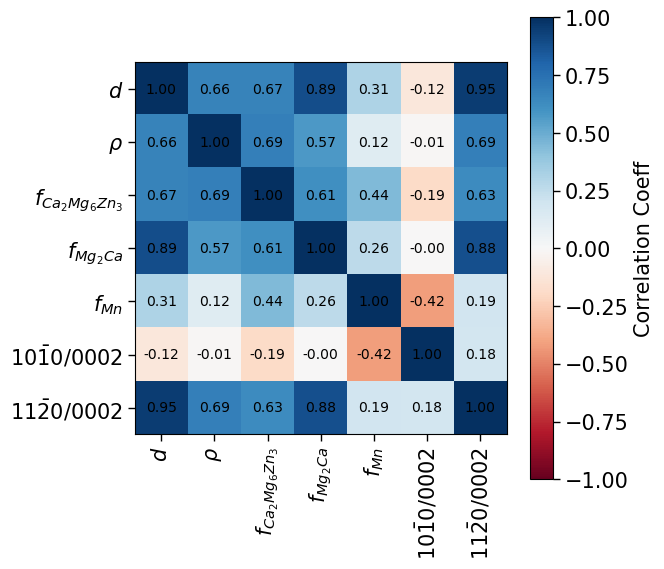

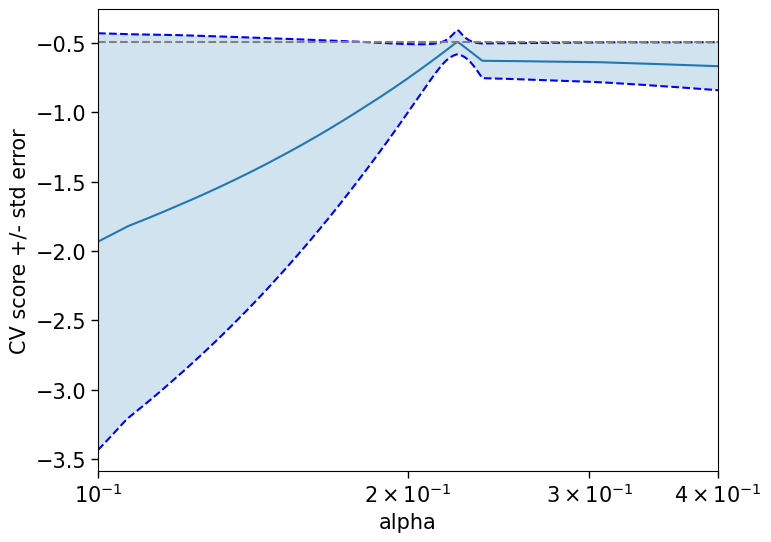

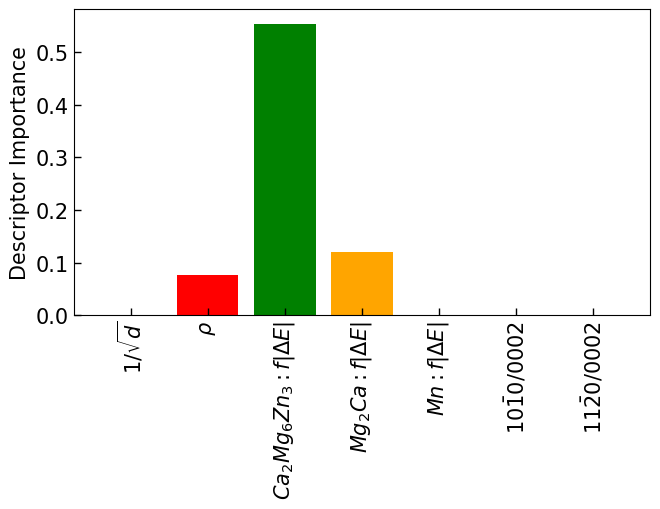

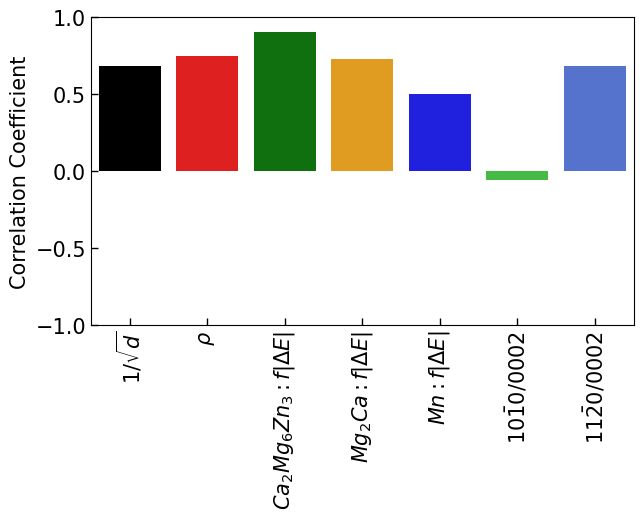

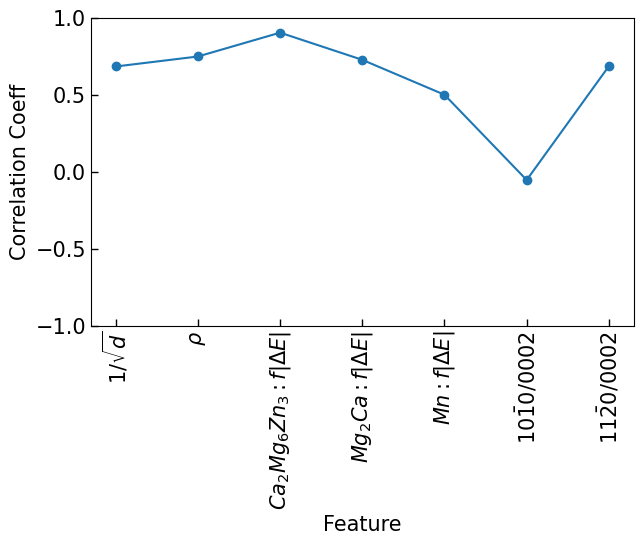

In [56]:
if __name__=="__main__":
    
    run_folder = '/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/Weihs_group_datasets/Sreenivas_MgAlloyColab/'
    with open(run_folder+'inputs.json', "r") as f:
        input_dict = json.load(f)
    
    input_type = input_dict['InputType']
    input_path = input_dict['InputPath']
    input_file = input_dict['InputFile']
    
    # input_type='MgAlloys_Hardness_phys'
    # input_file='MicroStructureHardness_physDesc.csv'
        
    input = inputs(input_type=input_type,input_path=input_path,input_file=input_file)
    XX, YY, descriptors = input.read_inputs()
    standardize_data = True

    if standardize_data:
        X_stand, scalerX = utilsd.standardize_data(XX)
        Y_stand, scalerY = utilsd.standardize_data(YY)
    else:
        X_stand = XX.to_numpy()
        Y_stand = YY       
    
    # Plots
    plots = plots_class(X_stand,Y_stand,descriptors)
    plots.plot_PCC_matrix(save_plot=False,file_name='microstructure_pcc.pdf')
    # plots.plot_input_features(XX,YY,'input_scatter_hardness_wo_time0.pdf',save_plot=False)
    
    # Feature Selection
    fs = feature_selection_algorithms(X_stand,Y_stand,test_size=0.1,random_state=40)
    
    # LASSO
    importance_df = fs.compute_lasso(descriptors,onlyImportant=False)
    plots.plot_lasso(importance_df, save_plot=True, 
                     tick_list_hardness=['$1/\sqrt{d}$',r'$\sqrt{\rho}$',
                                        r'$Ca_2Mg_6Zn_3:\frac{1}{\lambda}\ln{d_0}$',
                                        r'$Mg_2Ca:\frac{1}{\lambda}\ln{d_0}$',r'$Mn:\frac{1}{\lambda}\ln{d_0}$',
                                        r'${10\bar{1}0}/{0002}$',r'${11\bar{2}0}/{0002}$'],
                     tick_list_corrosion=['$1/\sqrt{d}$',r'$\rho$',
                                          r'$Ca_2Mg_6Zn_3:f|\Delta E|$',
                                          r'$Mg_2Ca:f|\Delta E|$',
                                          r'$Mn:f|\Delta E|$',
                                          r'${10\bar{1}0}/{0002}$',r'${11\bar{2}0}/{0002}$'],
                     tick_list=['$d$',r'$\rho$',
                                 r'$f_{Ca_2Mg_6Zn_3}$',
                                 r'$f_{Mg_2Ca}$',
                                 r'$f_{Mn}$',
                                 r'${10\bar{1}0}/{0002}$',r'${11\bar{2}0}/{0002}$'],
                     which_target=input_type)
    
   
    #PCC
    # fs.compute_pearson_corr_coeff(X_stand,Y_stand,descriptors,onlyImportant=False)
    plots.plot_PCC_target(save_plot=True,                     
                          tick_list_hardness=['$1/\sqrt{d}$',r'$\sqrt{\rho}$',
                                        r'$Ca_2Mg_6Zn_3:\frac{1}{\lambda}\ln{d_0}$',
                                        r'$Mg_2Ca:\frac{1}{\lambda}\ln{d_0}$',r'$Mn:\frac{1}{\lambda}\ln{d_0}$',
                                        r'${10\bar{1}0}/{0002}$',r'${11\bar{2}0}/{0002}$'],
                          tick_list_corrosion=['$1/\sqrt{d}$',r'$\rho$',
                                          r'$Ca_2Mg_6Zn_3:f|\Delta E|$',
                                          r'$Mg_2Ca:f|\Delta E|$',
                                          r'$Mn:f|\Delta E|$',
                                          r'${10\bar{1}0}/{0002}$',r'${11\bar{2}0}/{0002}$'],
                          tick_list=['$d$',r'$\rho$',
                                 r'$f_{Ca_2Mg_6Zn_3}$',
                                 r'$f_{Mg_2Ca}$',
                                 r'$f_{Mn}$',
                                 r'${10\bar{1}0}/{0002}$',r'${11\bar{2}0}/{0002}$'],
                          which_target=input_type)
    
    # XGBoost
    # fs.compute_xgboost(X_stand,Y_stand,descriptors,onlyImportant=False)
    
    

KeyError: 'Grain_size_mean'

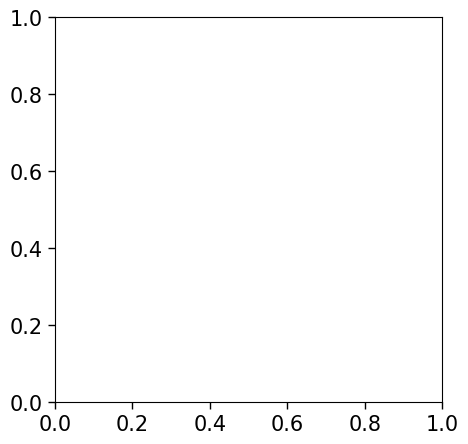

In [6]:
save_plot = False

fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(XX['Grain_size_mean'],XX['Ca2Mg6Zn3'],'rd-')
ax.set_xlabel('Grain Size')
ax.set_ylabel('Vol. Frac of Ca$_2$Mg$_6$Zn$_3$')
if save_plot:
    plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                'Weihs_group_datasets/Sreenivas_MgAlloyColab/figures/gs_ca2mg6zn3.pdf',
                bbox_inches='tight')
            

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(XX['Grain_size_mean'],XX['Mg2Ca'],'rd-')
ax.set_xlabel('Grain Size')
ax.set_ylabel('Vol. Frac of Mg$_2$Ca')
if save_plot:
    plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                'Weihs_group_datasets/Sreenivas_MgAlloyColab/figures/gs_mg2ca.pdf',
                bbox_inches='tight')
    

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(XX['Disloc_den'][1:],XX['10-10/0002'][1:],'rd-')
ax.set_xlabel('Dislocation Density')
ax.set_ylabel(r'{10$\bar{1}$0}/{0002}')
ax.set_xlim([7.5e+14,3.2e15])
if save_plot:
    plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                'Weihs_group_datasets/Sreenivas_MgAlloyColab/figures/disDen_ca2mg6zn3_wo_time0.pdf',
                bbox_inches='tight')
            

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(XX['Disloc_den'][1:],XX['11-20/0002'][1:],'rd-')
ax.set_xlabel('Dislocation Density')
ax.set_ylabel(r'{11$\bar{2}$0}/{0002}')
ax.set_xlim([7.5e+14,3.2e15])
if save_plot:
    plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                'Weihs_group_datasets/Sreenivas_MgAlloyColab/figures/disDen_mg2ca_wo_time0.pdf',
                bbox_inches='tight')

In [ ]:
save_plot = True
fig, ax = plt.subplots(figsize=(5, 5))
time_hrs=[0.001, 0.01666667,0.033333333,0.08333333,0.25,0.5,1.0,4.0,16.0,64.0,128.0]
plt.semilogx(time_hrs,np.power(XX['Disloc_den_sqrt'],2),'rd-')
ax.set_ylabel('Dislocation Density')
ax.set_xlabel('time [hrs]')

if save_plot:
    plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                'Weihs_group_datasets/Sreenivas_MgAlloyColab/figures/disDen_time.pdf',
                bbox_inches='tight')

In [ ]:
save_plot = True
fig, ax = plt.subplots(figsize=(5, 5))
time_hrs=[0.001, 0.01666667,0.033333333,0.08333333,0.25,0.5,1.0,4.0,16.0,64.0,128.0]
plt.semilogx(time_hrs,YY,'rd-')
ax.set_ylabel('Corrosion Rate')
ax.set_xlabel('time [hrs]')

if save_plot:
    plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                'Weihs_group_datasets/Sreenivas_MgAlloyColab/figures/hardness_time.pdf',
                bbox_inches='tight')